In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import cm
from timeit import default_timer as timer
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline

Pi = np.pi

Using the code in the notes as a model, numerically solve the KP2 equation
$$
u_{\tau} = -\frac{1}{6}\partial_{\xi}^{3}u - \frac{3}{4}\partial_{\xi}u^{2} - \frac{1}{2}\partial_{\xi}^{-1}\partial_{y}^{2}u,
$$
over a periodic domain given by $[-L,L]\times[-L,L]$ for the initial condition 
$$
u(\xi,y,0) = \sin\left(\frac{\pi}{L}\xi\right)\cos^{3}\left(\frac{\pi}{L}y\right).
$$
However, instead of an IMEX scheme, use a RK-4 scheme with an integrating factor.  Writing the Fourier-transformed version of the equation as 
$$
\hat{u}_{\tau} = \mathcal{L}\hat{u} + \mathcal{N}(\hat{u}),
$$
this means we first introduce the transformation
$$
\hat{u} = e^{\mathcal{L}\tau}\tilde{u},
$$
so that we perform the RK-4 method on 
$$
\tilde{u}_{\tau} = e^{-\mathcal{L}\tau}\mathcal{N}\left(e^{\mathcal{L}\tau}\tilde{u}\right).
$$
Note, the tensor form used throughout the numerical solution of the KP2 equation makes $\mathcal{L}$ an array, so finding the exponential in time is straightforward.  

Now, as discussed in class, the integrating-factor based RK-4 scheme is not implemented in the most straightforward of ways.  To wit, we are always trying to really find $\hat{u}_{n+1}$ from $\hat{u}_{n}$.  So

1.) Describe the implementation of an efficient version of the RK-4 with integrating factor scheme.  See Trefethen's book on Pseudospectral methods, Ch. 9 for hints and guidance.  

2.) Determine, using relative measurments of output, how the accuracy of your method varies with choice of the number of modes $K$ and the time step $\delta t$.  Try to find the treshhold of stability for your method, which is to say, what is the largest time step for a given choice of $K$ that still gives you a resonable result for a reasonable length of simulation time.  

3.) Now, run and compare to the results from the IMEX scheme in the notes.  The big issue to address here is which method lets you take the larger time step while still maintaining a relatively high level of accuracy.  Here you will need to make relative comparisons between the two methods.  


**Answers**

**Part 1**

To implement an as-efficient-as-possible RK4 scheme, we first need to define our linear operator $\mathcal{L}$ as

$$
\mathcal{L}=-\frac{1}{6}\partial_{\xi}^{3}-\frac{1}{2}\partial_{\xi}^{-1}\partial_{y}^{2},
$$

and our nonlinear operator $\mathcal{N}$ as

$$
\mathcal{N}=-\frac{3}{4}\partial_{\xi}.
$$

Then, keeping in mind that what we want is to go from ${\bf \hat{u}}_{n}$ to ${\bf \hat{u}}_{n+1}$, we follow the notes from the lecture to derive

\begin{align}
k_{1}=\delta{t}\mathcal{N}({\bf \hat{u}}_{n})\\
k_{2}=\delta{t}\mathcal{N}(e^{(\mathcal{L}\delta{t}/2)} ({\bf \hat{u}}_{n}+k_{1}/2))\\
k_{3}=\delta{t}\mathcal{N}(e^{(\mathcal{L}\delta{t}/2)} {\bf \hat{u}}_{n}+(k_{2}/2))\\
k_{4}=\delta{t}\mathcal{N}(e^{(\mathcal{L}\delta{t})}{\bf \hat{u}}_{n}+e^{(\mathcal{L}\delta{t}/2)}k_{3}),
\end{align}

which are the $k$'s of our RK4 scheme which will return

$$
{\bf \hat{u}}_{n+1}=e^{(\mathcal{L}\delta{t})}{\bf \hat{u}}_{n}+\frac{1}{6}\left(e^{(\mathcal{L}\delta{t})}k_{1}+\frac{1}{2}e^{(\mathcal{L}\delta{t}/2)}(k_{2}+k_{3})+k_{4}\right),
$$

which will be inverse-fourier-transformed back to physical space to be plotted.

Below is the code implemented for the RK4 scheme.

In [10]:
def nonlin(Dx,u,KT):
    uphys = (np.fft.ifft2(u.reshape(KT,KT))).real #reshaping u as a KTxKT matrix and inverse fourier transform it
    unl = np.fft.fft2(uphys*uphys)
    return Dx*unl.flatten()

In [59]:
def rk4(Dx,u,Lop,KT,dt):
    k1 = dt*nonlin(Dx,u,KT)
    k2 = dt*nonlin(Dx,(np.exp(Lop*dt/2.))*(u+k1/2.),KT)
    k3 = dt*nonlin(Dx,(np.exp(Lop*dt/2.))*u+(k2/2.),KT)
    k4 = dt*nonlin(Dx,(np.exp(Lop*dt))*u+(np.exp(Lop*dt/2.))*k3,KT)
    return ((np.exp(Lop*dt))*u+1./6.*((np.exp(Lop*dt))*k1+1./2.*((np.exp(Lop*dt/2.))*(k2+k3))+k4))

In [100]:
def kp_solverRK4(K,Llx,tf,dt): #I have noticed that if you put dt as an argument of the solver you cut off running time
                             
        
    # Total number of modes in simulation is KT=2*K
    # Domain is over [-Llx,Llx]
    # Simulation is run to time tf
    
    #dt = 1e-2
    Nsteps = int(np.round(tf/dt))
    
    KT = 2*K
    KTT = KT**2
    
    Xmesh = np.linspace(-Llx,Llx,KT,endpoint=False)
    Xxmesh, Yymesh = np.meshgrid(Xmesh, Xmesh)

    Dds = 1j*Pi/Llx*np.concatenate((np.arange(K+1),np.arange(-K+1,0,1,)),0)
    Dy = np.kron(Dds,np.ones(KT))
    Dx = np.kron(np.ones(KT),Dds)
    
    Dx3 = -1./6.*Dx**3.
    Dy2 = -1./2.*Dy**2.
    
    Dxn1sb = np.concatenate((np.array([0.]),1./Dds[1:]),0) #makes the first element zero and then it gives you the
                                                            #inverse of dds starting from the second element on
                                                            #avoid division by zero
    Dxn1 = np.kron(np.ones(KT),Dxn1sb)
    
    Dx = -3./4.*Dx
     
    Lop = 5./6.*Dx3+1./2.*(Dxn1*Dy2)#LOP for Runge-Kutta #after several trials this combo worked the best
    
    wn = np.zeros(KTT,dtype=np.complex128) # Initialize the solution vector and associated parts of multi-step solver.
    wnp1 = np.zeros(KTT,dtype=np.complex128)

    nln = np.zeros(KTT,dtype=np.complex128)

    u0 = np.fft.fft2(np.sin(Pi/Llx*Xxmesh)*(np.cos(Pi/Llx*Yymesh))**3.)
    wn[:] =  u0.flatten() # Fourier transform of initial condition
    
    nln[:] = nonlin(Dx,wn,KT)



    for jj in xrange(Nsteps): # Run the time stepper i.e. how we get from time t_n = ndt to time t_(n+1)
        nln[:] = nonlin(Dx,wn,KT) # Computation of nonlinearity
        wnp1[:] = rk4(Dx,wn,Lop,KT,dt)
        wn[:] = wnp1

    
    wnp1 = (np.fft.ifft2(wnp1.reshape(KT,KT)).real)
    fig = plt.figure(figsize=(8, 6))
    plt.pcolor(Xxmesh, Yymesh, wnp1, cmap='RdBu')
    plt.xlabel(r"$\xi$")
    plt.ylabel("$y$")
    plt.title('KP2 with the RK4 Scheme')
    plt.colorbar()

**Part 2**

As the DFT prefers the use of multiples of $2$ for the number of modes, we are going to start with $K=2^{5}=32$, which, most likely, will produce a very-resolution picture, but it would be important to see if we can still appreciate the dynamics of the solution even with such a relatively low number of modes $K$. The time step will be of $10^{-2}$ units of time.

Elapsed time is 2.29700708389


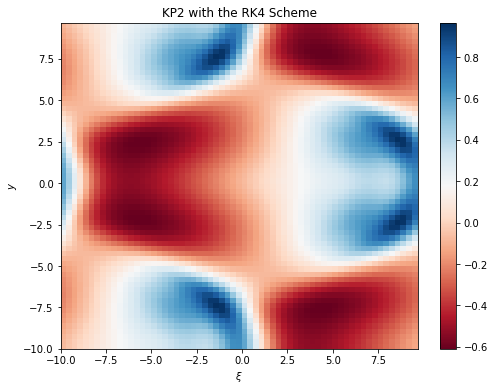

In [101]:
start = timer()
kp_solverRK4(32,10,5.,1e-2)
end = timer()
ttot = np.str(end - start)
print("Elapsed time is " + ttot)

As anticipated, the picture is extremely low-resolution, yet we can appreciate the evolution of the solution, with areas of higher elevation indicated in blue and lower elevation in red, with the whiter areas indicating the transition between the two.
However, the picture looks quite different from the one obtained with IMEX scheme in the lecture, therefore let us try to increase the final time to $t_{f}=10$ and see what happens.

Elapsed time is 4.4634270668


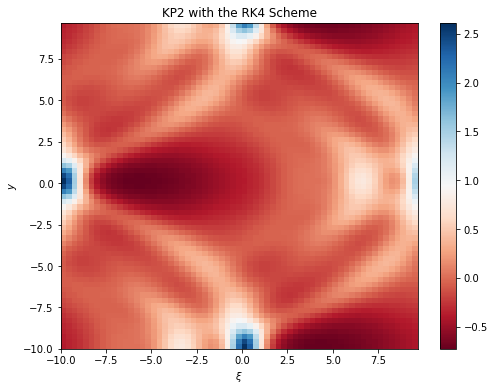

In [102]:
start = timer()
kp_solverRK4(32,10,10.,1e-2)
end = timer()
ttot = np.str(end - start)
print("Elapsed time is " + ttot)

Thus, even if the running time doubles, we see that now the solution matches with the one obtained in class with the IMEX schem. This already speaks to the inherent inefficiency of the RK4 scheme, as it requires a final time that is twice as much the one for the IMEX (more to this in Part 3).

Now that we have found the optimal $t_{f}$, let us double the number of modes to $K=64$ in order to increase the resolution.

Elapsed time is 17.5698299408


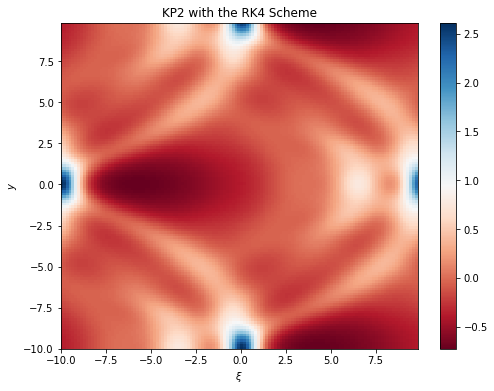

In [81]:
start = timer()
kp_solverRK4(64,10,10.,1e-2)
end = timer()
ttot = np.str(end - start)
print("Elapsed time is " + ttot)

The higher number of modes gives us a much clearer and resolved picture, while not changing the dynamics of the solution, which indicates that our results have been correctly predicted even by the lower number of modes used before. Also, the computing time is not terribly long (less than $18$ seconds), thus we have not wasted much computing power to increase the resolution of the solution.

Now, let us go up by a factor of $2$ in the number of modes and observe the results.

Elapsed time is 77.3097250462


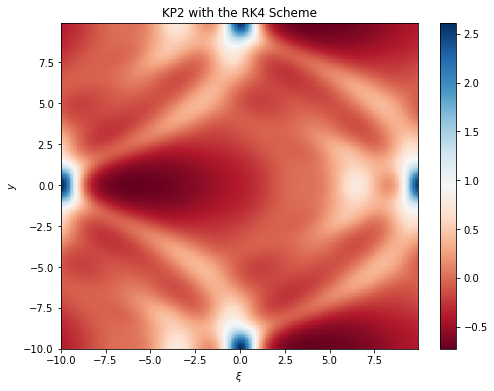

In [82]:
start = timer()
kp_solverRK4(128,10.,10.,1e-2)
end = timer()
ttot = np.str(end - start)
print("Elapsed time is " + ttot)

We have a not-insignificant gain in terms of resolution, but we do also quintuple the elapsed time for the computation, while not really gaining any new valuable information in terms of the dynamics. The gains in term of resolution do not seem to justify the so-much longer running time and such waste of computing power.

Therefore, it seems as $K=64$ is the optimal number of modes for the given $\delta{t}=10^{-2}$. Now let us see what happens as we increase the time step to $10^{-1}$.

Elapsed time is 2.56125307083


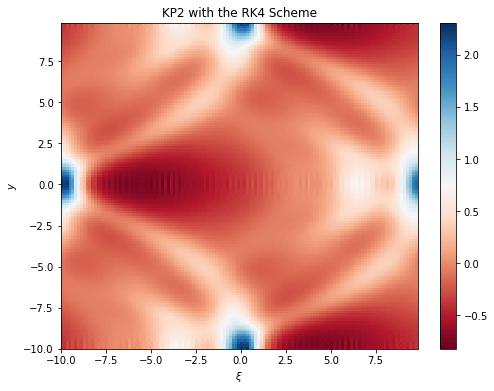

In [84]:
start = timer()
kp_solverRK4(64,10,10.,1e-1)
end = timer()
ttot = np.str(end - start)
print("Elapsed time is " + ttot)

That is really good. Increasing the time step by a factor of $10$ gave us comparable results in terms of accuracy to the ones obtained with $K=64$ and $\delta{t}=10^{-2}$ before. Moreover, increasing the time step saved a lot of computing power, as the elapsed time decreased from $17.6$ to $2.6$ . Therefore, we have gained speed without losing accuracy.
That being said, the picture does not look quite as nice in terms of resolution, as the plot seems to "break down" in some sections.This seems to suggest that we have possibly reached the treshold of stability for this method.

Thus, it seems reasonable to conclude that the optimal implementation, for the given final time $t_{f}=10$, of the RK4 scheme is given by using a number of modes $K=64$ and a time step $\delta{t}=10^{-2}$.

Let us see how far in time our algorithm can keep giving us reasonable results for the solution, or how the solution changes its dynamics as time proceeds.

Elapsed time is 26.2066001892


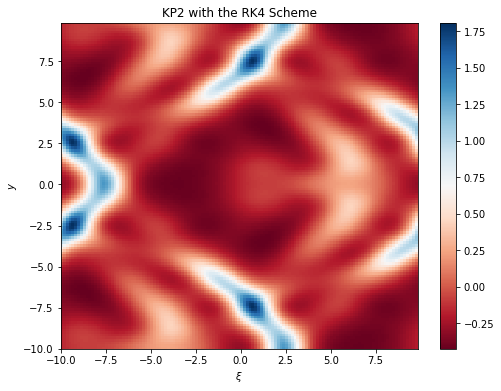

In [90]:
start = timer()
kp_solverRK4(64,10,15.,1e-2) #increased time step with K=128
end = timer()
ttot = np.str(end - start)
print("Elapsed time is " + ttot)

Thus, our solution has changed for the scheme run up to $t_{f}=15$. Even though the overall dynamics is still recognizable in the picture, obviously the solution is not the same. Let us see what happens if, for the same $t_{f}$, we decrease the time step to $10^{-3}$.

Elapsed time is 219.456662893


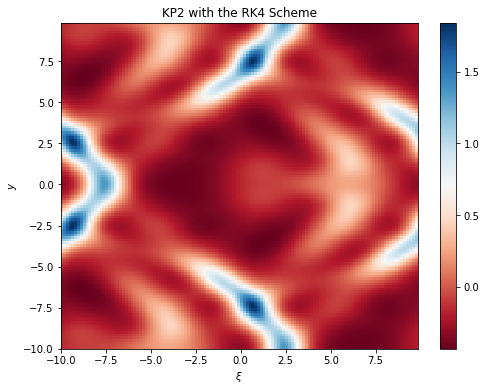

In [91]:
start = timer()
kp_solverRK4(64,10,15.,1e-3)
end = timer()
ttot = np.str(end - start)
print("Elapsed time is " + ttot)

So, we have an elapsed time that is almost ten times greater than the previous one (more than $3$ minutes) and the two pictures are basically equivalent.

In conclusion, all things considered, the threshold of stability for our methods seems to be $\delta{t}=10^{-1}$, as it allows us to obtain reasonale results, for a long-enough running time ($t_{f}=10$) and a number of modes as low as $K=64$. However, a time step of $10^{-2}$ gives us a clearer plot for a reasonable amount of computing power.

Elapsed time is 17.7778990269


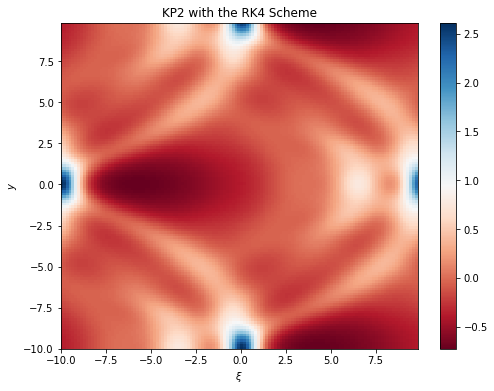

In [96]:
start = timer()
kp_solverRK4(64,10,10.,1e-2) #optimal implementation
end = timer()
ttot = np.str(end - start)
print("Elapsed time is " + ttot)

**Part 3: Comparison between IMEX and RK4**

Now let us compare the results from the RK4 scheme with those obtained with the IMEX scheme from the lecture. As the picture with $K=32$ seems to be too low-resolution, we start with $K=64$. We also begin our analysis with a time step $\delta{t}=10^{-2}$. Let us run both schemes up to $t_{f}=10$ at first.

In [103]:
def kp_solverIMEX(K,Llx,tf,dt):
    
    # Total number of modes in simulation is KT=2*K
    # Domain is over [-Llx,Llx]
    # Simulation is run to time tf
    
    #dt = 1e-2
    Nsteps = int(np.round(tf/dt))
    
    KT = 2*K
    KTT = KT**2
    
    Xmesh = np.linspace(-Llx,Llx,KT,endpoint=False)
    Xxmesh, Yymesh = np.meshgrid(Xmesh, Xmesh)

    Dds = 1j*Pi/Llx*np.concatenate((np.arange(K+1),np.arange(-K+1,0,1,)),0)
    Dy = np.kron(Dds,np.ones(KT))
    Dx = np.kron(np.ones(KT),Dds)
    
    Dx3 = -1./6.*Dx**3.
    Dy2 = -1./2.*Dy**2.
    
    Dxn1sb = np.concatenate((np.array([0.]),1./Dds[1:]),0) #makes the first element zero and then it gives you the
                                                            #inverse of dds starting from the second element on
                                                            #avoid division by zero
    Dxn1 = np.kron(np.ones(KT),Dxn1sb)
    
    Dx = -3./4.*Dx
    
    Lop = 1./(np.ones(KTT)-3.*dt/4.*(Dx3+Dxn1*Dy2)) #how to set up LOP: takes third der of x + 
                                                        #(inverse of x times second der of y) 
                                                        
    
    wn = np.zeros(KTT,dtype=np.complex128) # Initialize the solution vector and associated parts of multi-step solver.
    wnm1 = np.zeros(KTT,dtype=np.complex128)
    wnp1 = np.zeros(KTT,dtype=np.complex128)

    nln = np.zeros(KTT,dtype=np.complex128)
    nlnm1 = np.zeros(KTT,dtype=np.complex128)
    nlnm2 = np.zeros(KTT,dtype=np.complex128)
    nlnm3 = np.zeros(KTT,dtype=np.complex128)

    u0 = np.fft.fft2(np.sin(Pi/Llx*Xxmesh)*(np.cos(Pi/Llx*Yymesh))**3.)
    wn[:] =  u0.flatten() # Fourier transform of initial condition
    wnm1[:] = wn
    
    
    nln[:] = nonlin(Dx,wn,KT) # Computation of nonlinearity.  
    nlnm1[:] = nln
    nlnm2[:] = nlnm1
    nlnm3[:] = nlnm2
    
    for jj in xrange(Nsteps): # Run the time stepper i.e. how we get from time t_n = ndt to time t_(n+1)
        nln[:] = nonlin(Dx,wn,KT) # Computation of nonlinearity
        wnp1[:] = Lop*(wn + wnm1/3. + dt*(55./24.*nln - 59./24.*nlnm1 + 37./24.*nlnm2 - 3./8.*nlnm3)) - wnm1/3.
        wnm1[:] = wn
        wn[:] = wnp1
    
        nlnm3[:] = nlnm2
        nlnm2[:] = nlnm1
        nlnm1[:] = nln
    
    wnp1 = np.fft.ifft2(wnp1.reshape(KT,KT)).real
    fig = plt.figure(figsize=(8, 6))
    plt.pcolor(Xxmesh, Yymesh, wnp1, cmap='RdBu')
    plt.xlabel(r"$\xi$")
    plt.ylabel("$y$")
    plt.title("KP2 with IMEX scheme")
    plt.colorbar()

Elapsed time for IMEX is 2.57621407509
Elapsed time for RK4 is 17.4010388851


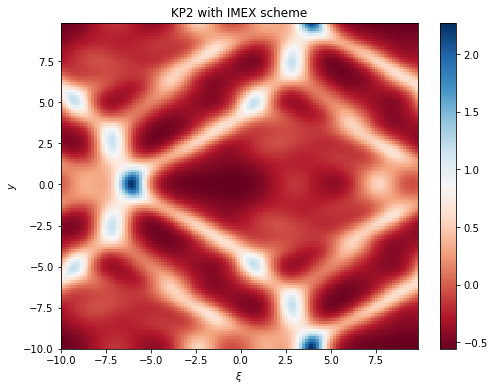

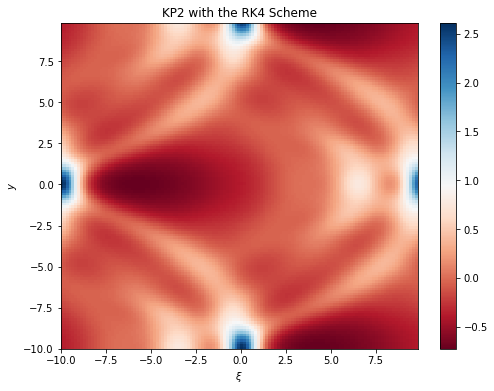

In [104]:
start = timer()
kp_solverIMEX(64,10,10.,1e-2)
end = timer()
ttot = np.str(end - start)
print("Elapsed time for IMEX is " + ttot)
start = timer()
kp_solverRK4(64,10,10.,1e-2)
end = timer()
ttot = np.str(end - start)
print("Elapsed time for RK4 is " + ttot)

We readily see that the two pictures seem quite different in terms of the proportion of the higher/lower elevation areas. The IMEX schemes seem to describe a much more complex dynamics for $t_{f}=10$. Also, the IMEX scheme is much more efficient and faster in its computation, as indicated by a running time that is more than $5$ times smaller than the RK4's. Thus, we can conclude that the IMEX scheme does a much better and faster job in reproducing the dynamics of the KP2.

Now, let us use our "optimal" configurations for both schemes and compare their results.

Elapsed time for IMEX is 1.53011584282
Elapsed time for RK4 is 17.4285130501


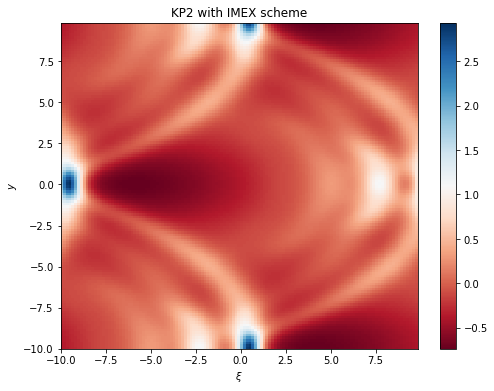

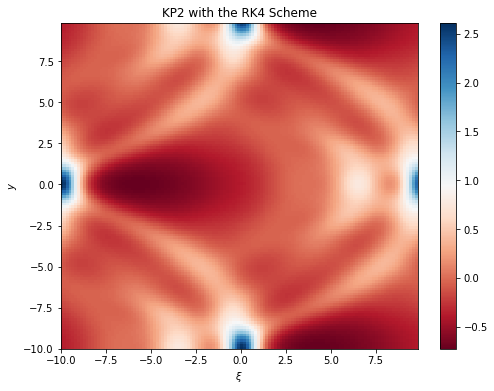

In [105]:
start = timer()
kp_solverIMEX(64,10,5.,1e-2) #tf=5 for IMEX
end = timer()
ttot = np.str(end - start)
print("Elapsed time for IMEX is " + ttot)
start = timer()
kp_solverRK4(64,10,10.,1e-2) #tf=10 for RK4
end = timer()
ttot = np.str(end - start)
print("Elapsed time for RK4 is " + ttot)

Now, the two pictures are basically equivalent. However, in terms of efficiency, it is not even close. The IMEX scheme is able to perform the task in less than $1/10$ of the time of the RK4 scheme.

Now, just to compare their running time when we increase the resolution of the grid, let us see what happens for both schemes with $K=128$, $t_{f}=5$ and $\delta{t}=10^{-2}$.

Elapsed time for IMEX is 6.11669397354
Elapsed time for RK4 is 39.3874089718


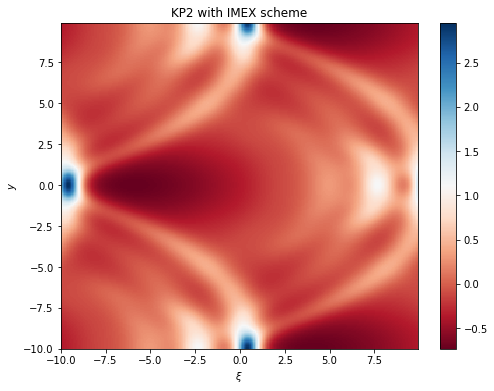

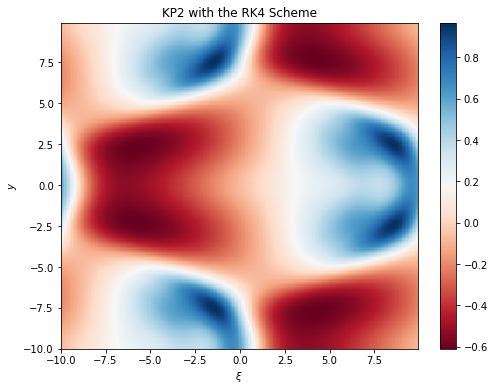

In [106]:
start = timer()
kp_solverIMEX(128,10,5.,1e-2)
end = timer()
ttot = np.str(end - start)
print("Elapsed time for IMEX is " + ttot)
start = timer()
kp_solverRK4(128,10,5.,1e-2)
end = timer()
ttot = np.str(end - start)
print("Elapsed time for RK4 is " + ttot)

The IMEX scheme gives excellent results in terms of resolution with a still reasonable running time, whereas the RK4 schemen takes more than $6$ times longer, showing its inherent inefficiency. Also, while the overall dynamics is somewhat preserved by both schemes, the two pictures that they provide are quite different.

Now, let us use a number of modes $K=128$ with their optimal $t_{f}$ and observe the results.

Elapsed time for IMEX is 6.4206340313
Elapsed time for RK4 is 77.3310620785


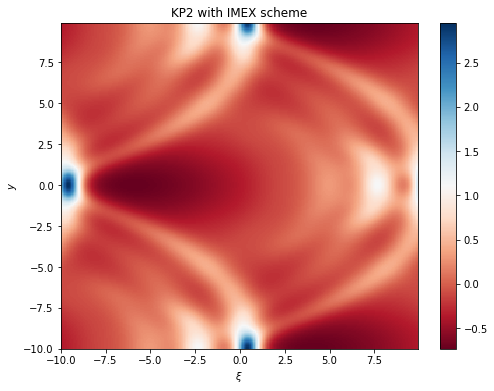

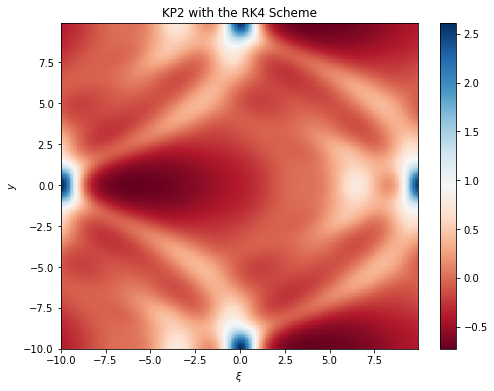

In [110]:
start = timer()
kp_solverIMEX(128,10,5.,1e-2) #shorter time step dt
end = timer()
ttot = np.str(end - start)
print("Elapsed time for IMEX is " + ttot)
start = timer()
kp_solverRK4(128,10,10.,1e-2) #shorter time step dt
end = timer()
ttot = np.str(end - start)
print("Elapsed time for RK4 is " + ttot)

We see that the two pictures are basically equivalent now, but the two running time have grown even further apart, with the RK4 being more than 12 times slower than the IMEX scheme.

Next, let us increase the time step $\delta{t}$ to $10^{-1}$, $t_{f}=5$ for $K=64$.

Elapsed time for IMEX is 0.69398188591
Elapsed time for RK4 is 1.41976094246


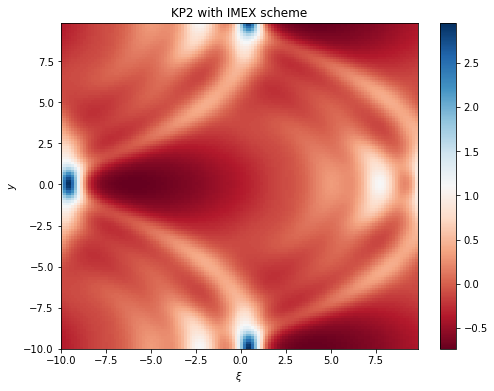

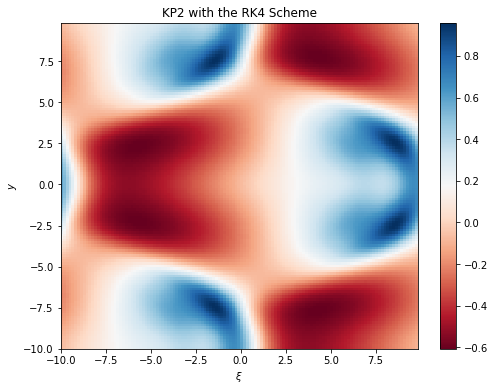

In [107]:
start = timer()
kp_solverIMEX(64,10,5.,1e-1) #shorter time step dt
end = timer()
ttot = np.str(end - start)
print("Elapsed time for IMEX is " + ttot)
start = timer()
kp_solverRK4(64,10,5.,1e-1) #shorter time step dt
end = timer()
ttot = np.str(end - start)
print("Elapsed time for RK4 is " + ttot)

Both schemes are pretty fast, with a difference of about $0.8$ seconds in terms of running time, with the IMEX scheme still being the faster and taking just a little over half a second to run. However, while they both keep their relative accuracy, once again the IMEX scheme gives us a much clearer picture of the situation.

Next, for the same time step, will bring the $t_{f}$ for IMEX and RK4 back to $5$ and $10$ respectively.

Elapsed time for IMEX is 0.618208169937
Elapsed time for RK4 is 2.38748002052


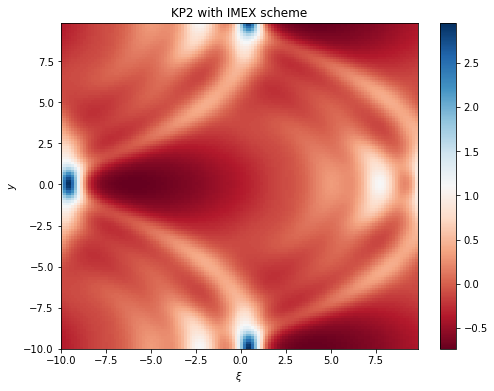

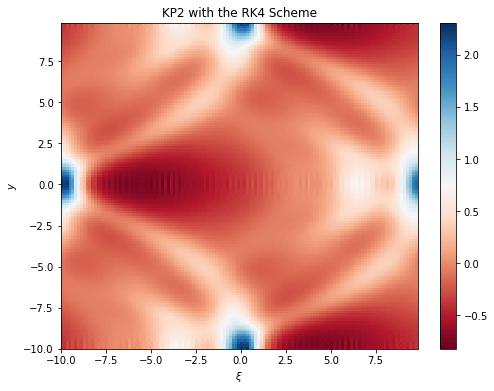

In [108]:
start = timer()
kp_solverIMEX(64,10,5.,1e-1) #greater final time tf
end = timer()
ttot = np.str(end - start)
print("Elapsed time for IMEX is " + ttot)
start = timer()
kp_solverRK4(64,10,10.,1e-1) #greater final time tf
end = timer()
ttot = np.str(end - start)
print("Elapsed time for RK4 is " + ttot)

The schemes are both pretty quick, with the IMEX still being the faster by about $1.8$ seconds, and the pictures now even seem  more similar to one another. Yet, the plot of the KP2 obtained through the IMEX scheme seems to have a higher resolution and it looks better overall.

Therefore, we can conclude that the IMEX scheme is superior to the RK4 in terms of accuracy, resolution and running time, when it comes to reproducing the dynamics of the KP2 equation.